### Throwback: which SNPs are associated with mouse hair color again?

Remember the GWAS task, where we investigated which SNPs were significantly associated with the coat color of mice? Machine learning ties in well with this task. We know random forests are useful to determine the importance of different features when classifying samples. We could ask a random forest to predict hair color from genotype data, and then look at what features it considered important while doing it.

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn import metrics as sme

Load the genotype and color data. Make sure you index the genotype data explicitly by passing `index_col="Locus"` to the csv reader.

In [9]:
genotype = pd.read_csv("../files_day_two/aad0189_DataFileS4.txt", sep="\t", comment="@", index_col="Locus")
colors = pd.read_csv("../files_day_two/sample_data.csv", index_col=0, names=["color"], na_values='x').dropna()['color']

Split the genotype data into two dataframes: one should contain the metadata (first 3 columns) and the other the actual genotype data. Call them `geno_metadata` and `geno`.

Remember, `sklearn` takes samples in rows, and our samples correspond to mice strains here, so transpose `geno`. Also make sure that the indices of the `geno` and `color` DFs line up with each other: only keep the intersection of their indices. Index objects support intersection.

In [40]:
geno_metadata = genotype.iloc[:,:3]
geno = genotype.iloc[:,3:].T

# Keep intersection
inter = geno.index.intersection(colors.index)

# Drop rows which are not in the intersection
geno_dropped = geno.loc[inter]
color_dropped = colors.loc[inter]

Encode the B/D/H/U genotype information with numbers. You can use -1/0/0/1 or 0/1/1/2 for B/H/U/D respectively. Either way, it's best to encode H with a value between B and D since it stands for hybrid.

As for encoding colors: they are already numbers. We won't even transform them to the binary black/non-black labels like we did on day 3, we will just feed it them to the predictor as they are. Let the random forest figure out the associations for black/grey/white/brown.

In [44]:
# convert cell values to numerical values by applymap a encode dictionary
encode = {'B': -1, 'D': 0, 'H': 0, 'U': 1}
geno_enc = geno_dropped.applymap(encode.get)

Train a random forest classifier with all the data. Make sure you use a lot of trees in that forest (a few thousand should be good) so we can get fine-grained values for feature importances. The more decision trees you run the data on, the clearer it gets which features it tests most often.

In [82]:
# Random forest classifier
clf = RandomForestClassifier(random_state=0, n_estimators=1000)
clf.fit(geno_enc, color_dropped)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Now take the feature importance vector, and add it to the `geno_metadata` DataFrame as a new column. Sort by that column (obviously descending), and look at the most important SNP ids. Compare them with your GWAS data -- no need to load anything, just look at the Manhattan plot from day 3.

In [83]:
# Importance vector
importances = clf.feature_importances_
import_frame = pd.DataFrame(importances, index=geno_metadata.index)

# Add to metadata
geno_metadata['importances'] = import_frame
geno_metadata.sort_values(by='importances', ascending=False)

,Chr,cM,Mb,importances
Locus,,,,
rs3708061,4,41.281,80.950126,0.016320
rs13477796,4,41.281,78.698063,0.015836
rs13480283,9,45.892,75.877786,0.015454
rs3725904,9,46.179,76.983761,0.014368
rs3658567,4,40.995,76.484833,0.013054
CEL-4_74066970,4,40.708,75.438626,0.011817
rs3685573,9,46.179,76.102533,0.011429
rs3674482,9,47.074,77.217283,0.011311
rs3724833,9,45.892,74.735876,0.011084


If you took the effort to load that mouse genotype and color data, you might as well take a peek at the performance of the predictor. Calculate a cross-validated accuracy score, and create a confusion matrix for the four colors. You can lower the number of trees used by an order of magnitude, since cross-validation makes things more time intensive.

In [84]:
kf = StratifiedKFold(n_splits=3, shuffle=True)
cv_probs = cross_val_predict(clf, geno_enc, color_dropped, cv=kf, method='predict_proba')

And finally, create a ROC diagram. You know how to make them for binary classifiers... but this isn't a binary classification task. What should it look like when you have 4 labels instead of just 2?

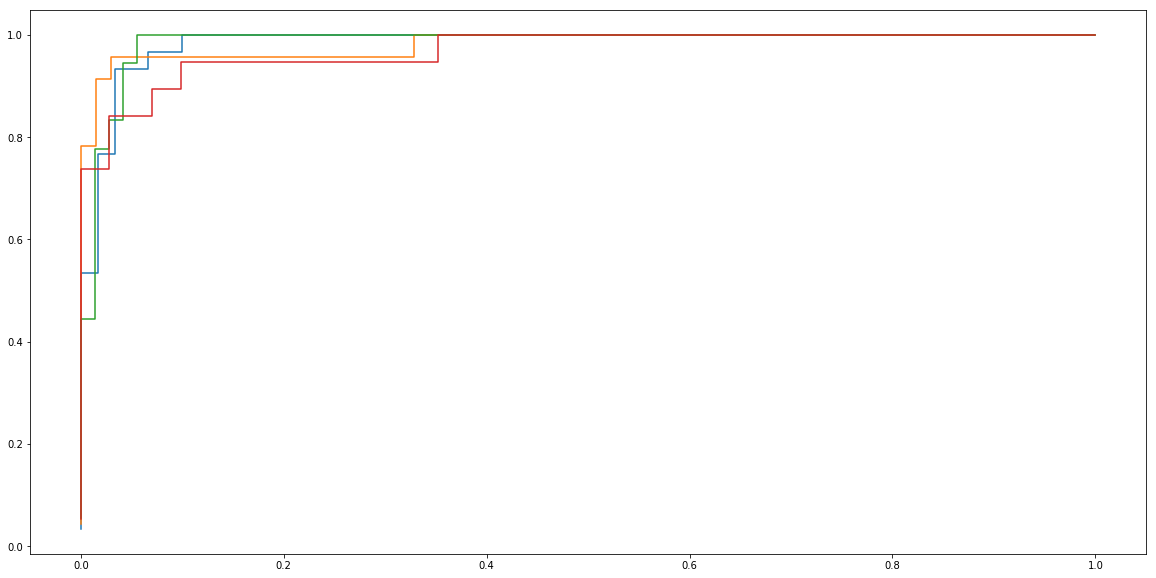

In [85]:
# Calculate roc curve parameters for all 4 classes
res1 = sme.roc_curve(color_dropped==1.0, cv_probs[:,0])
res2 = sme.roc_curve(color_dropped==2.0, cv_probs[:,1])
res3 = sme.roc_curve(color_dropped==3.0, cv_probs[:,2])
res4 = sme.roc_curve(color_dropped==4.0, cv_probs[:,3])

# Plot ROC curve for all 4 classes
plt.figure(figsize=(20,10))

plt.plot(res1[0], res1[1])
plt.plot(res2[0], res2[1])
plt.plot(res3[0], res3[1])
plt.plot(res4[0], res4[1])